### Test of data instantiation

In [ ]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader 
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import os
from torchmetrics import FBetaScore, Accuracy
from torchvision.utils import draw_bounding_boxes

import torchvision.transforms as T
from torchvision.transforms import functional as F

import pandas as pd
from src import dfmaker
from src import BWDatasets

from paddleocr import PaddleOCR
import paddle


ModuleNotFoundError: No module named 'dfmaker'

### Ensure Reproducibility

In [ ]:
seed = 115
generator = torch.Generator()
generator.manual_seed(seed)
np_generator = np.random.default_rng(seed=seed)

### Activate CUDA

In [ ]:
device = torch.device('cpu')

# Make sure the notebook is deterministic if training on gpu
if torch.cuda.is_available():
    device = torch.device('cuda')
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False

print(f'Cuda availability is: {torch.cuda.is_available()}')  # Returns True if a GPU is available
print(f"Training on device {device}.")

Cuda availability is: True
Training on device cuda.


In [ ]:
# Lyngøy
# label_path = "dataset/datasets/lyngoy/ringcodes.csv"
# image_path = "dataset/datasets/lyngoy/images"
# bb_path = "dataset/datasets/lyngoy/labels"

# RF
label_path = "dataset/datasets/rf/ringcodes.csv"
image_path = "dataset/datasets/rf/images"
bb_path = "dataset/datasets/rf/labels"

# ringmerkingno
# label_path = "dataset/datasets/ringmerkingno/ringcodes.csv"
# image_path = "dataset/datasets/ringmerkingno/images"
# bb_path = "dataset/datasets/ringmerkingno/labels"

max_n = 1000
transform = T.Compose([
    # T.Resize((64,32)),
    T.Resize((224,112)),
    T.Lambda(lambda x: F.rotate(x, 270, expand=True))
])

df = dfmaker.make_dataframe(labels_path=label_path, img_path=image_path, bb_path=bb_path, max_n=max_n)

exp_dataset = BWDatasets.TrainDataSet(df=df, transform=transform, max_n=None)


In [ ]:
def draw_image(img):
    img_uint8 = BWDatasets.tensor_to_numpy(img)
    plt.figure(figsize=(12,12))
    plt.imshow(img_uint8)
    plt.axis("off")
    plt.show()

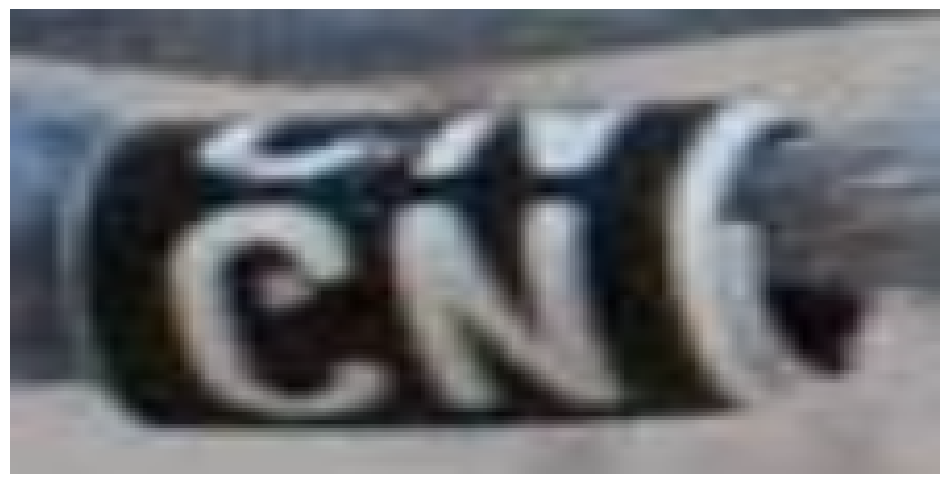

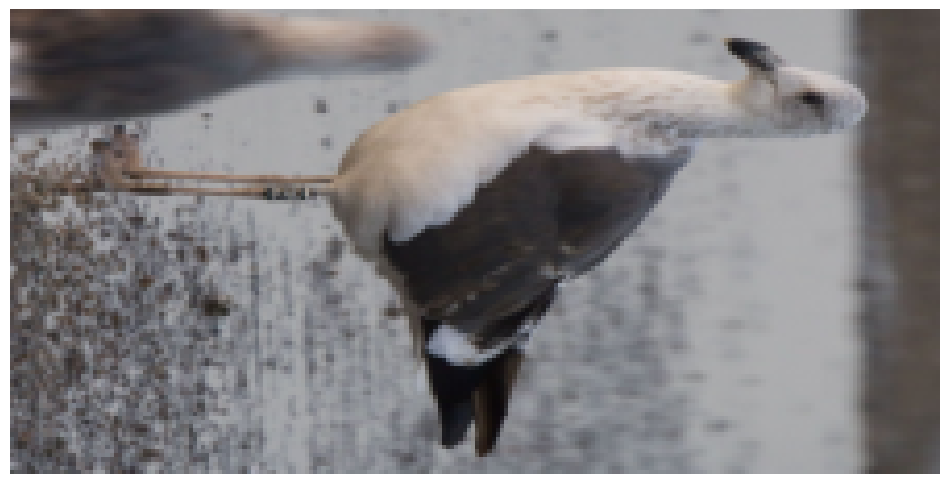

In [ ]:
data = exp_dataset[4]

draw_image(data["ocr_image"])
draw_image(data["image"])

In [ ]:
stop



NameError: name 'stop' is not defined

In [ ]:
paddle.device.set_device("gpu:0")
ocr = PaddleOCR(lang="en", 
        #    text_detection_model_dir="src/models/paddleOCR/det", 
        #    text_recognition_model_dir="src/models/paddleOCR/rec", 
        #    textline_orientation_model_dir="src/models/paddleOCR/cls", 
           use_doc_orientation_classify=True, 
           use_doc_unwarping=True, 
           use_textline_orientation=True, device='gpu')


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 5074.78it/s]
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 7844.71it/s]
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 3503.53it/s]
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [

In [ ]:

exp_loader = DataLoader(dataset=exp_dataset, batch_size=64, shuffle=True, generator=generator)


In [ ]:
def prediction(dataloader):
    preds = []
    targets = []
    count = 0
    for data in dataloader:
        count +=1
        print(f'Batch {count} of {len(dataloader)}')
        images = BWDatasets.tensor_to_numpy(data["ocr_image"])
        labels = data["label"][0]
        for i, image in enumerate(images):
            
            result = ocr.predict(image)

            pred = result[0]["rec_texts"]

            if not pred:
                pred = ['Not Found']

            preds.append(pred[0])

            label = labels[i]
            
            targets.append(label)

            # print("-------------------")
            # print(f'Prediction: {pred}')
            # print(f'Actual: {label}')

            # plt.figure(figsize=(4,2))
            # plt.imshow(image, cmap="gray")
            # plt.axis("off")
            # plt.show()
    return preds, targets


In [ ]:
def evaluate_model(preds, labels):
    print(f'preds: {preds}')
    print(f'labels: {labels}')
    
    # Boolean mask for the predictions and the labels
    # Prediction = 1 if it is correct, 0 otherwise
    # Labels are always = to 1
    bin_preds = [int(pred == label) for pred, label in zip(preds, labels)]
    bin_labels = [1]*len(labels)

    preds_tensor, labels_tensor = torch.tensor(bin_preds), torch.tensor(bin_labels)
    fbeta = FBetaScore(task='binary', beta=0.5)
    acc = Accuracy(task='binary')

    print(f'Model F1 Score: {fbeta(preds_tensor, labels_tensor)}')
    print(f'Model Accuracy: {acc(preds_tensor, labels_tensor)}')
    # print(f'preds: {preds_tensor}')
    # print(f'labesl: {labels_tensor}')

In [ ]:
preds, labels = prediction(exp_loader)


Batch 1 of 16
Batch 2 of 16
Batch 3 of 16
Batch 4 of 16
Batch 5 of 16
Batch 6 of 16
Batch 7 of 16
Batch 8 of 16
Batch 9 of 16
Batch 10 of 16
Batch 11 of 16
Batch 12 of 16
Batch 13 of 16
Batch 14 of 16
Batch 15 of 16
Batch 16 of 16


In [ ]:
evaluate_model(preds=preds, labels=labels)


preds: ['Not Found', 'JN869', 'Not Found', 'Not Found', '', 'CEOPE', 'Not Found', '1SOCE', 'J036C', 'Not Found', 'K808', 'Not Found', 'Not Found', 'J761', 'H9ZI', 'Not Found', 'Not Found', '1725V', 'OEEA', 'Not Found', 'H', 'Not Found', 'JJg4C', 'Not Found', 'Not Found', 'JCOTM', 'J701', '760', 'Not Found', 'Not Found', 'Not Found', 'JE49C', '37600', '076CC', '39000', 'J9291', 'Not Found', 'Not Found', 'JC49T', 'Not Found', 'Not Found', 'Not Found', '1S115', 'H97C', 'J761T', 'Not Found', '78081', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'JE06X', 'Not Found', 'JL050', 'JN869', 'JE99U', 'A808C', 'Not Found', 'Not Found', 'vOan', 'Not Found', 'Not Found', 'Not Found', '12131', 'Not Found', 'J808V', 'Not Found', 'H9ZU', 'Not Found', 'Not Found', '07600', 'Not Found', 'A8U81', 'E', 'Not Found', 'JG6', 'Not Found', 'Not Found', 'Not Found', '3680', 'JE49C', 'A8081', 'Not Found', 'Not Found', 'JL084', 'anov', '07600', 'Not Found', 'JL084', 'Not Found', 'Not Found', 'JE23X', 'AZ0', 